# Test for spectral MC Simulations

In [1]:
from numpy import ndarray

import luxpy as lx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import empir19nrm02 as empir

from empir19nrm02.spectral import McSpectrumX
from empir19nrm02.tools import sumMC, draw_values_gum
from empir19nrm02.f1prime import py_f1PrimeG

# Parameter for Standard $f_{1}^{'}$

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 100

In [3]:
def plotHistScales( data, fig=None, ax=None, bins=50, density=True,
             title='Title', xLabel='xLabel', yLabel=None):
    plt.hist(data[1:], bins=bins, density=density)
    plt.xlabel(xLabel)
    plt.title(title)
    if yLabel is None:         
        plt.ylabel('Probability')
    else:
        plt.ylabel(yLabel)
    
    # stat over all
    [value, interval] = sumMC(data, Coverage=0.95)
   
    plt.axvline(interval[0])
    plt.axvline(interval[1])
    plt.show()
    print( 'Value=', value, 'Inteval(95%)=', interval[1]-interval[0])

def plotHistScalesWl( data, fig=None, ax=None, bins=50, density=True,
              title =  'Histogram of wavelength scale',
              xLabel = '$\Delta \lambda / nm$'):
    plotHistScales( data,fig=fig, bins=bins, density=density, title=title, xLabel=xLabel)        

def plotHistScalesValue( data, fig=None, ax=None, bins=50, density=True,
              title =  'Histogram of value scale',
              xLabel = '$\Delta y / a.u.$'):
    plotHistScales( data, fig=fig, ax=ax, bins=bins, density=density, title=title, xLabel=xLabel)        


In [4]:
# Noch nicht alle Argumente implementiert - teilweise nur angedacht!
def analyse_stat( spectrumMC, fig=None, ax=None, scalewl=True, scaleValue=False):
    _trials=len( spectrumMC)-1
    _res=len(spectrumMC[0].spd.wl)
    analyse = np.zeros( (_trials, res))
    for i in range(_trials):
        if scalewl == True: 
            analyse[i]=spectrumMC[i+1].spd.wl - spectrumMC[0].spd.wl
        if scaleValue == True:
            analyse[i]=spectrumMC[i+1].spd.value - spectrumMC[0].spd.value
    statData = np.zeros( (res, 2))
    statData[:,0] = np.mean(analyse, axis=0)
    statData[:,1] = np.std(analyse, axis=0)
    corrData = np.corrcoef(analyse.T)
    

    if fig is None:
        fig1, ax = plt.subplots()
    else:
        fig1 = fig
    color = 'tab:red'
    ax.set_xlabel('$\lambda / nm$')
    ax.set_ylabel('$\mu$', color=color)
    ax.plot(spectrumMC[0].spd.wl, statData[:,0], color=color)
    ax.tick_params(axis='y', labelcolor=color)

    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('$\sigma$', color=color)  # we already handled the x-label with ax1
    ax2.plot(spectrumMC[0].spd.wl, statData[:,1], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig1.tight_layout()  # otherwise the right y-label is slightly clipped
    
    if scalewl == True:
        plt.title('Data Statistics Wavelength')
    else:
        plt.title('Data Statistics Value')
    if fig is None:
        plt.show()

    if scalewl == True:
        plotHistScalesWl( analyse)
    else:
        plotHistScalesValue( analyse)

    cax = plt.imshow(corrData, vmin=-1, vmax=1, cmap="jet", interpolation="nearest")
    plt.colorbar(cax, ticks=[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])    
    plt.show()

i= wl_noise_nc


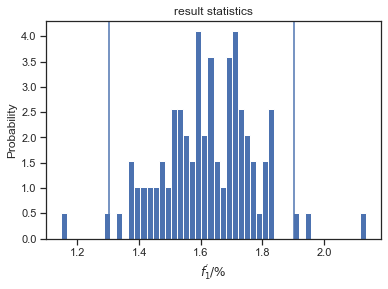

Value= [1.6064993269665269, 0.22026849503805765] Inteval(95%)= 0.6001096964886281
i= wl_noise_c


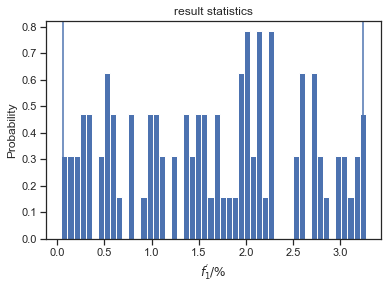

Value= [1.6240471182736211, 0.9310675116757967] Inteval(95%)= 3.1834101685673373
i= value_noise_nc


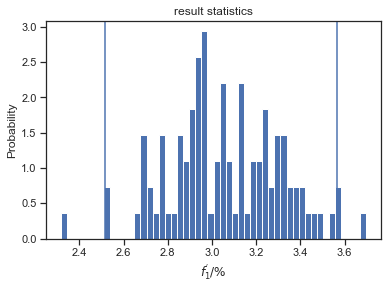

Value= [3.0267841820613914, 0.39452791143949767] Inteval(95%)= 1.0483462645840667
i= value_noise_c


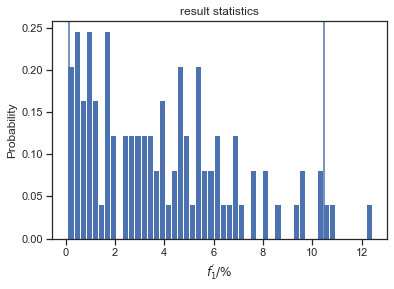

Value= [3.8701768798596192, 2.938100771586377] Inteval(95%)= 10.313561298573317
i= all


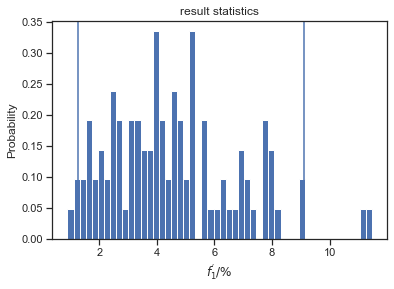

Value= [4.496980196557416, 2.236109230871428] Inteval(95%)= 7.822657744221056


In [14]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], \
    wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
    kind = 'S')
res = len(lxCmfInterpolate[0])

wl=lxCmfInterpolate[0].reshape(1,res)
value=lxCmfInterpolate[2].reshape(1,res)
spd_init = np.r_[wl, value]

mcComponents = 1

mc_enable = { 'wl_noise_nc': True,
              'wl_noise_c': True,
              'value_noise_nc': True,
              'value_noise_c': True,
              'all': True,
              }

for iMC in mc_enable:
    if mc_enable[iMC] == False: continue

    array = np.ndarray((trials,),dtype=object)
    result1 = np.zeros( trials)
    result3 = np.zeros( (3, trials))

    for i in range(trials):
        array[i] = McSpectrumX(spd_init)

    #left the first one without noise
    result1[0] = py_f1PrimeG( array[0].spd.wl, array[0].spd.value)
    result3[:,0] = lx.xyz_to_Yxy(array[0].spd.to_xyz(relative=False).value)

    if iMC==mcComponents: final_run = True
    for i in range(1, trials):
        if mc_enable['wl_noise_nc'] and (iMC == 'wl_noise_nc' or iMC == 'all'):
            array[i].add_wl_noise_nc(array[0], 0., 1., distribution='uniform')
        if mc_enable['wl_noise_c'] and (iMC == 'wl_noise_c' or iMC == 'all'):
            array[i].add_wl_noise_c(array[0], 0., 1., distribution='uniform')
        if mc_enable['value_noise_nc'] and (iMC == 'value_noise_nc' or iMC == 'all'):
            array[i].add_value_noise_nc(array[0], 0., 0.01, distribution='normal')
        if mc_enable['value_noise_c'] and (iMC == 'value_noise_c' or iMC == 'all'):
            array[i].add_value_noise_c(array[0], 0., 0.01, distribution='normal')

        result1[i] = py_f1PrimeG(array[i].spd.wl, array[i].spd.value)
        result3[:,i] = lx.xyz_to_Yxy(array[i].spd.to_xyz(relative=False).value)


    print("i=", iMC)
    #analyse_stat( array, scalewl=True, scaleValue=False)
    #analyse_stat( array, scalewl=False, scaleValue=True)

    plotHistScales( 100.*result1, title = "result statistics", xLabel="$f_{1}^{'} / \%$")


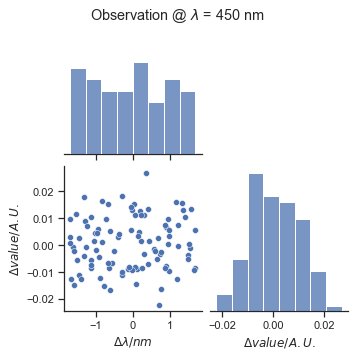

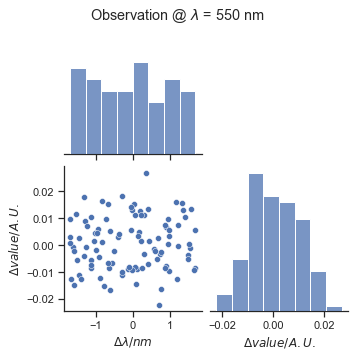

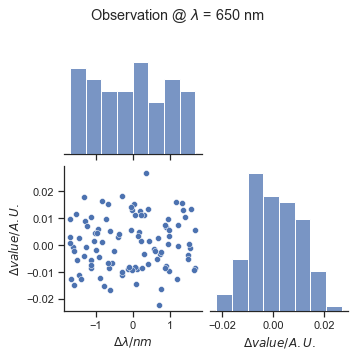

In [23]:
import seaborn as sns
import pandas as pd

def get_data_step( size_to_minimize, max_data_to_display=1000):
    if size_to_minimize < max_data_to_display:
        step=1
        disp_count = size_to_minimize
    else:
        step=int(size_to_minimize/max_data_to_display)
        disp_count = int(size_to_minimize/step)
    return disp_count, step

def seaborn_plot_basedata( array, wavelength_to_observe = 550):
    pos, = np.where(np.isclose(array[0].spd.wl, wavelength_to_observe))

    disp_array_count, step = get_data_step( array.shape[0])
    disp_array = np.zeros((2, disp_array_count-1))
    for i in range(disp_array_count-1):
        disp_array[0,i]=array[i*step+1].spd.wl[pos]-array[0].spd.wl[pos]
        disp_array[1,i]=array[i*step+1].spd.value[0,pos]-array[0].spd.value[0,pos]

    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T, columns=['$\Delta\lambda / nm$','$\Delta value / A.U.$'])
    grid=sns.pairplot(df, corner=True)
    plotTitle='Observation @ $\lambda$ = {} nm'
    grid.fig.suptitle( plotTitle.format(wavelength_to_observe))

seaborn_plot_basedata(array, wavelength_to_observe = 450)
seaborn_plot_basedata(array, wavelength_to_observe = 550)
seaborn_plot_basedata(array, wavelength_to_observe = 650)

In [27]:
def seaborn_plot_result( result):

    disp_array_count, step = get_data_step( result.shape[1])
    disp_array = np.zeros((3, disp_array_count-1))
    for i in range(disp_array_count-1):
        disp_array[0,i]=result[0, i*step+1] / result[0,0]
        disp_array[1,i]=result[1, i*step+1] - result[1,0]
        disp_array[2,i]=result[2, i*step+1] - result[2,0]

    sns.set_theme(style="ticks")
    df = pd.DataFrame(data=disp_array.T, columns=['$Y_{\mathrm{rel}} / A.U.$','$\Delta x$','$\Delta y$'])
    grid=sns.pairplot(df, corner=True)
    plotTitle='Observation Yxy result'
    grid.fig.suptitle( plotTitle.format())

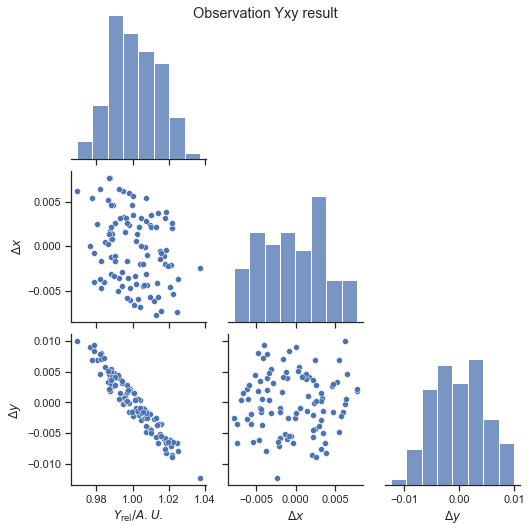

In [28]:
seaborn_plot_result( result3)

In [9]:
#mcComponents = 4
#
#array = np.ndarray((trials,),dtype=object)
#for i in range(trials):
#    array[i] = McSpectrumX(spd_init)
#
#for iMC in range(mcComponents):
#    for jMC in range(iMC,mcComponents):
#        print (iMC, jMC)
#        str = 'MCFile_{}_{}'
#        fileName = str.format(iMC, jMC)
#        np.save( fileName, array)
#